# Gaussian Process Regression

# //TODO LIST
## Data import
## Data cleaning
### duplicate remover
### 

In [1166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


global_seed = 0

## Data Import

In [1167]:
url = 'https://raw.githubusercontent.com/LeoPeink/GPRegression/refs/heads/master/sale_clean.csv'
df = pd.read_csv(url, index_col=0) #read csv from gitHub
df.reset_index(inplace=True)       #reset index to default

#Warning about columns 10 and 11. They are useless for regression, so will be removed anyway from the dataset later.
#df.head(5)

C:\Users\Leo\AppData\Local\Temp\ipykernel_1608\2676104874.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, index_col=0) #read csv from gitHub


## Data Cleaning
The dataset contains a lot of duplicate rows. After careful consideration and seeing that the original dataset was scraped on immobiliare.it, I concluded that it was probably a scraping error.
In the unlikely case the duplicate rows were actual different houses with the same exact carachteristics, the adapted policy was to remove them to avoid eccessively reducing the dataset variance.

Also, the amount of features is way overkill for what we need in our didactic demo. All features except prezzo, stanze, bagni and superficie will be removed.

Finally, due to the scope of the project (house price regression), all records with missing price were also dropped.

In [1168]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop duplicate rows across all columns
    df = df.drop_duplicates()
    # Drop columns: 'regione', 'citta' and 27 other columns
    df = df.drop(columns=['regione', 'citta', 'quartiere', 'datetime', 'posti auto', 'bagni per stanza', 'ultimo piano', 'stato', 'classe energetica', 'vista mare', 'riscaldamento centralizzato', 'arredato', 'balcone', 'impianto tv', 'esposizione esterna', 'fibra ottica', 'cancello elettrico', 'cantina', 'giardino comune', 'giardino privato', 'impianto allarme', 'portiere', 'piscina', 'villa', 'intera proprieta', 'appartamento', 'attico', 'loft', 'mansarda'])
    # Drop rows with missing data in every column
    df = df.dropna()
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,prezzo,bagni,stanze,superficie
0,78000.0,1.0,3.0,67.0
1,460000.0,2.0,3.0,75.0
2,387000.0,2.0,4.0,160.0
3,257000.0,2.0,5.0,136.0
4,370000.0,2.0,3.0,105.0


# Exploratory analysis
The single features are analized using the following framework:

## Pricing hell
The price feature has HORRIBLE values.
The majority of houses are almost for free and some houses cost more euros than the amount of sand grains on earth (10^20). The IQR strategy does not work for the low outliers here, so I decidet to do 0.05 trimming:

Raw price distribution:
count    1.915000e+04
mean     2.868995e+31
std      1.652777e+33
min      1.000000e+00
25%      1.185000e+03
50%      1.630000e+05
75%      3.300000e+05
max      1.075000e+35
Name: prezzo, dtype: float64


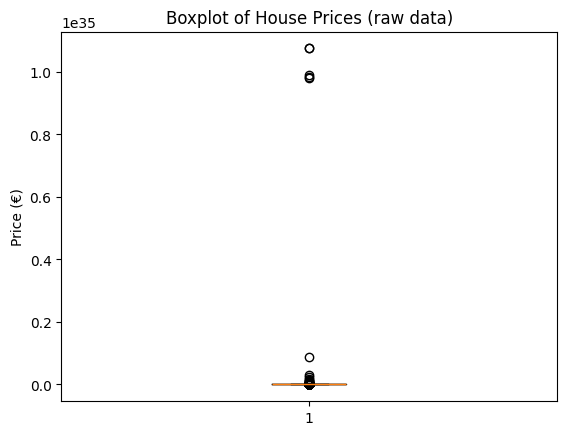

In [1169]:
#boxplot with distribution of every feature
print('Raw price distribution:')
print(df_clean['prezzo'].describe())
plt.boxplot(df_clean['prezzo'])
plt.title('Boxplot of House Prices (raw data)')
plt.ylabel('Price (€)')
plt.show()


5% quantile: 400.0
95% quantile: 1280000.0
count    1.739600e+04
mean     2.065281e+05
std      2.268789e+05
min      4.000000e+02
25%      1.300000e+03
50%      1.600000e+05
75%      3.050000e+05
max      1.280000e+06
Name: prezzo, dtype: float64


,prezzo,bagni,stanze,superficie
0,78000.0,1.0,3.0,67.0
1,460000.0,2.0,3.0,75.0
2,387000.0,2.0,4.0,160.0
3,257000.0,2.0,5.0,136.0
4,370000.0,2.0,3.0,105.0


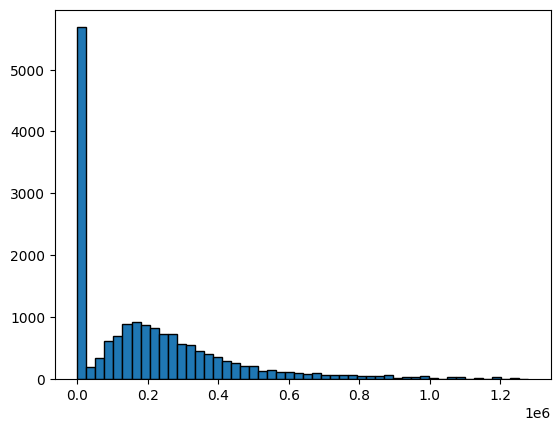

In [1170]:
#remove outliers from prezzo using 15% and 95% quantiles
q_low = df_clean['prezzo'].quantile(0.05)
print (f"5% quantile: {q_low}")
q_high = df_clean['prezzo'].quantile(0.95)
print (f"95% quantile: {q_high}")
df_clean = df_clean[(df_clean['prezzo'] >= q_low) & (df_clean['prezzo'] <= q_high)]
#plot histogram of 'prezzo'
plt.hist(df_clean['prezzo'], bins=50, edgecolor='black')

print(df_clean['prezzo'].describe())
df_clean.head()

Very low prices are considered irrealistic, and fit well (along the very high ones we had from the start) with the bad scraping hypothesis. For our objective, dropping all the prices under 10.000€ seems reasonable.

(array([ 92., 251., 451., 627., 770., 928., 832., 799., 769., 803., 668.,
        534., 602., 439., 378., 288., 285., 242., 237., 174., 150., 140.,
        138.,  86.,  82., 116.,  98.,  76.,  57.,  72.,  56.,  43.,  42.,
         46.,  65.,  20.,  30.,  43.,  50.,   9.,  24.,  14.,  36.,   4.,
         14.,   5.,  29.,   5.,  21.,   8.]),
 array([  10000.,   35400.,   60800.,   86200.,  111600.,  137000.,
         162400.,  187800.,  213200.,  238600.,  264000.,  289400.,
         314800.,  340200.,  365600.,  391000.,  416400.,  441800.,
         467200.,  492600.,  518000.,  543400.,  568800.,  594200.,
         619600.,  645000.,  670400.,  695800.,  721200.,  746600.,
         772000.,  797400.,  822800.,  848200.,  873600.,  899000.,
         924400.,  949800.,  975200., 1000600., 1026000., 1051400.,
        1076800., 1102200., 1127600., 1153000., 1178400., 1203800.,
        1229200., 1254600., 1280000.]),
 <BarContainer object of 50 artists>)

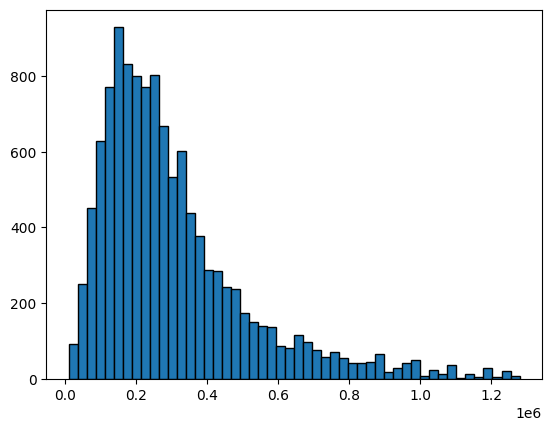

In [1171]:
df_clean = df_clean[(df_clean['prezzo'] >= 10000)]
plt.hist(df_clean['prezzo'], bins=50, edgecolor='black')


The next step in preprocessing was to apply a log scale to "Prezzo", to keep as much data as possible in the dataset for the regression. the result is a monomodal distribution.

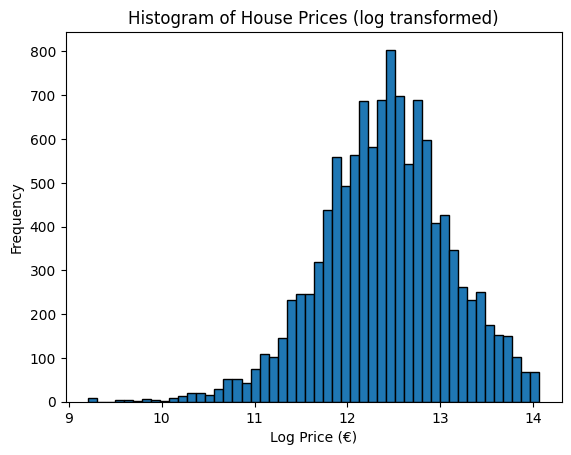

In [1172]:
df_clean['prezzo'] = np.log(df_clean['prezzo'])  #apply log transformation to 'prezzo'
#plot histogram of 'prezzo' after log transformation
plt.hist(df_clean['prezzo'], bins=50, edgecolor='black')
plt.title('Histogram of House Prices (log transformed)')
plt.xlabel('Log Price (€)')
plt.ylabel('Frequency')
plt.show()

## Bathrooms cleaning (lol)

Let's see how the bathrooms are distribuited: 

Bathrooms distribution:
count    11748.000000
mean         1.550136
std          0.619033
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: bagni, dtype: float64


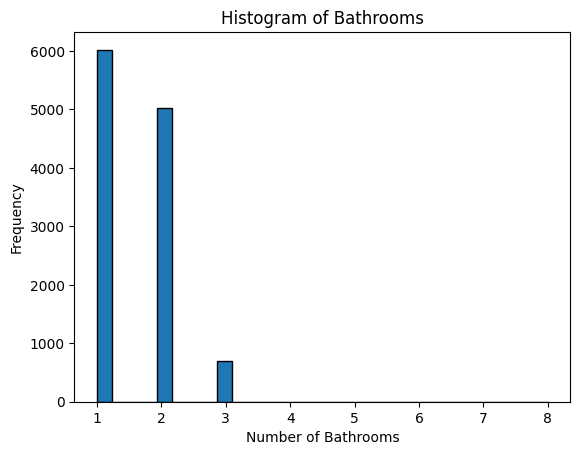

             prezzo         bagni        stanze    superficie
count  11748.000000  11748.000000  11748.000000  11748.000000
mean      12.403435      1.550136      3.464845    108.740552
std        0.691799      0.619033      1.015940     44.216480
min        9.210340      1.000000      1.000000      1.000000
25%       11.970350      1.000000      3.000000     78.000000
50%       12.425208      1.000000      3.000000    100.000000
75%       12.853829      2.000000      4.000000    131.000000
max       14.062371      8.000000      5.000000    300.000000
Superfice distribution:
count    11748.000000
mean       108.740552
std         44.216480
min          1.000000
25%         78.000000
50%        100.000000
75%        131.000000
max        300.000000
Name: superficie, dtype: float64


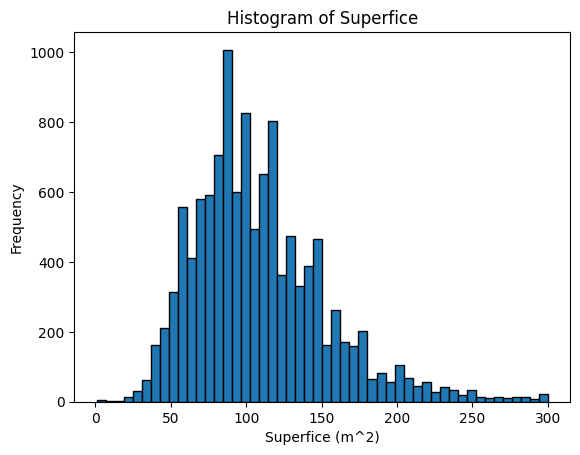

In [1173]:
#check the bagni distribution
print('Bathrooms distribution:')
print(df_clean['bagni'].describe())
plt.hist(df_clean['bagni'], bins=30, edgecolor='black')
plt.title('Histogram of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')
plt.show()
df_clean.head()
print(df_clean.describe())

#how to check if missing rooms are correlated with low superfice?
#check the superfice distribution
print('Superfice distribution:')
print(df_clean['superficie'].describe())
plt.hist(df_clean['superficie'], bins=50, edgecolor='black')
plt.title('Histogram of Superfice')
plt.xlabel('Superfice (m^2)')
plt.ylabel('Frequency')
plt.show()


## Rooms time!
Let's now see how the rooms are distributed:


Rooms distribution:
count    11748.000000
mean         3.464845
std          1.015940
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: stanze, dtype: float64


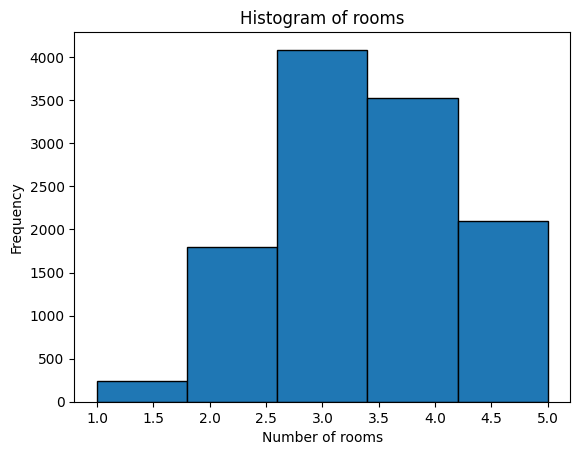

             prezzo         bagni        stanze    superficie
count  11748.000000  11748.000000  11748.000000  11748.000000
mean      12.403435      1.550136      3.464845    108.740552
std        0.691799      0.619033      1.015940     44.216480
min        9.210340      1.000000      1.000000      1.000000
25%       11.970350      1.000000      3.000000     78.000000
50%       12.425208      1.000000      3.000000    100.000000
75%       12.853829      2.000000      4.000000    131.000000
max       14.062371      8.000000      5.000000    300.000000


In [1174]:
#check the rooms distribution
print('Rooms distribution:')
print(df_clean['stanze'].describe())
plt.hist(df_clean['stanze'], bins=5, edgecolor='black')
plt.title('Histogram of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Frequency')
plt.show()
df_clean.head()
print(df_clean.describe())

## Correlation analysis
Let's see if our variables are correlated. I expected stronger correlations given the real estate nature of the dataset. The low correlation between prezzo and superficie might be explained by the removed geographical information of our data. Still, given the HORRORS i saw in the original dataset's distribution, I feel happy anyway.

Correlation matrix:


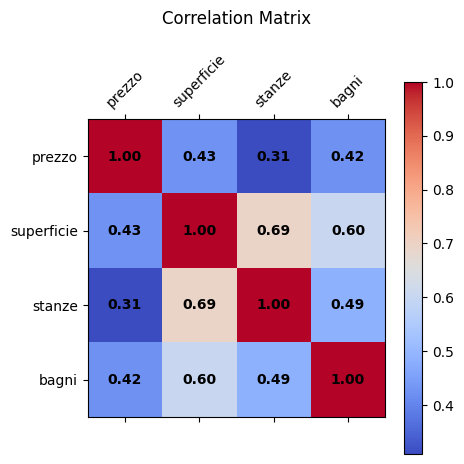

              prezzo  superficie    stanze     bagni
prezzo      1.000000    0.425538  0.308573  0.424408
superficie  0.425538    1.000000  0.692508  0.604868
stanze      0.308573    0.692508  1.000000  0.485091
bagni       0.424408    0.604868  0.485091  1.000000


In [1175]:
#correlation matrix with values inside
corr = df_clean[['prezzo', 'superficie', 'stanze', 'bagni']].corr()
print('Correlation matrix:')
plt.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()

# Add correlation values to each square
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f'{corr.iloc[i, j]:.2f}', 
                ha='center', va='center', fontsize=10, fontweight='bold')

plt.title('Correlation Matrix', pad=20)
plt.show()

print(corr)

# Regression analysis
The goal is now to predict prezzo (dependent variable) using bagni, stanze and superficie as features (independent variables).
We will inport the necessary module first:

In [1176]:
#import standard scaler
from sklearn.preprocessing import StandardScaler
#import personal library from local folder
from LPEG import lpeg_regressions as lpr
from LPEG import lpeg_preprocessing as lpp

#import train test split
from sklearn.model_selection import train_test_split

### Train-test split
I proceed to split the dataset in train and test.

In [1177]:
#Prepare data for regression:
X = df_clean[['superficie', 'stanze', 'bagni']]
y = df_clean['prezzo']
#LINEAR REGRESSION
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=global_seed)

### Baseline model
We need to define a baseline model to check if our regressors learn something.
The go-to baseline for regression is the MEAN CONSTANT PREDICTOR. Our model(s) will have to do better than this.

In [1178]:
def evaluate_model(y, y_pred, out=False):
    MSE = np.mean((y - y_pred)**2)
    RMSE = np.sqrt(MSE)
    perc_error = np.exp(RMSE)-1
    if out:
        print(f"MSE: {MSE:.4f}")
        print(f"RMSE: {RMSE:.4f}")
        print(f"Error in %: {perc_error:.2%}")
    return MSE, RMSE, perc_error

y_baseline = np.mean(y_train) #NB: baseline on training data only to avoid data leakage

print("\n--- Baseline model errors: ---\n")

print("Baseline model performance on TRAINING data:")
baseline_train_errors = evaluate_model(y_train, y_baseline, out=True)
print("\nBaseline model performance on TEST data:")
baseline_test_errors = evaluate_model(y_test, y_baseline, out=True)


--- Baseline model errors: ---

Baseline model performance on TRAINING data:
MSE: 0.4754
RMSE: 0.6895
Error in %: 99.28%

Baseline model performance on TEST data:
MSE: 0.4910
RMSE: 0.7007
Error in %: 101.51%


The baseline model makes a relative error > 1. As we can see, the baseline model is... suboptimal.
Keeping those numbers in mind, let's train (hopefully) smarter models:
## Linear regression

First thing first, we need to scale the data and add the bias term:

In [1179]:
#Data scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) #NB: do not fit the scaler on the test set to avoid data leakage

#Add bias term
X_train = lpp.add_bias_term(X_train)
X_test  = lpp.add_bias_term(X_test)

Now we can learn: here we used GD, but a closed form solution is also feasable.

In [1180]:


#Linear regression using gradient descent
lr_ws, lr_losses = lpr.gradientDescent(lpr.squaredLossGradient, lpr.squaredLoss, X_train, y_train, lam = 0,w_0=None, alpha=0.1, t_max=1000, tol=1e-15, fixed_alpha=True)

#extract weights and losses from GD output:
w_lr = lr_ws[-1] #final weights
print("LR weights: ",w_lr)

print("LR Training loss: ",lr_losses[-1])
lr_y_pred_train = X_train @ w_lr

print("\n--- Linear regression errors: ---\n")
print("Training:")
lr_train_errors = evaluate_model(y_train, lr_y_pred_train, out=True)
print("Test:")
lr_test_errors = evaluate_model(y_test, X_test @ w_lr, out=True)



Converged in 519 iterations at tol=1e-15
LR weights:  [1.24041245e+01 1.87671492e-01 1.79552352e-04 1.81621379e-01]
LR Training loss:  0.3657352561997139

--- Linear regression errors: ---

Training:
MSE: 0.3657
RMSE: 0.6048
Error in %: 83.08%
Test:
MSE: 0.3914
RMSE: 0.6256
Error in %: 86.94%


The model does slightly better. The relative error went down, but we can do better:
## Ridge regression
Let's now try using Ridge Regression to estimate our data (NB: we reused X_train from the above segment)
We will use K-Fold Cross Validation alongside with Telescopic Search to find an optimal Lambda.

In [1181]:
from sklearn.model_selection import KFold
#LAMBDA IS A SCALAR - Telescopic search should work well
#create first lam array of powers of 10:
#10^-5 -> 10^3
folds = 5 #number of folds for cross validation
zooms = 5 #number of zooms for telescopic search
low_exp = -5
high_exp = 3
lambdas = np.logspace(low_exp,high_exp,num=9)
for zoom in range(zooms):
    lam_error = np.zeros(len(lambdas))
    for i,lam in enumerate(lambdas):
        lam_error[i] = 0
        kf = KFold(n_splits=folds, shuffle=True, random_state=global_seed)
        for train_idx, val_idx in kf.split(X_train, y_train):
            X_fold, X_val = X_train[train_idx], X_train[val_idx]
            y_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx] #NB: use ILOC since y_train is a pandas series
            w = lpr.closed_form_ridge_regression(X_fold, y_fold, lam)
            lam_error[i] += np.mean((y_val - X_val @ w)**2) / kf.n_splits
        #print(f"Average validation loss for lam = {lam:.1e} => {lam_error[i]:.4f}")
        best_idx = np.argmin(lam_error)
    best_lam = lambdas[best_idx]

    #print(f"Zoom {zoom+1}")
    #print(f"Best lambda: {best_lam:.2e}")
    #print(f"Validation loss: {lam_error[best_idx]:.4f}")

    #telescopic search
    log_best = np.log10(best_lam)
    half_width = (high_exp - low_exp) / 4  #interval half width
    low_exp = log_best - half_width
    high_exp = log_best + half_width
    lambdas = np.logspace(low_exp,high_exp,num=9)
lam = lambdas[-1]

#RETRAIN RR with best lambda
w_rr = lpr.closed_form_ridge_regression(X_train, y_train, lam)
print("\n--- Ridge regression errors: ---\n")
print("Training:")
rr_train_errors = evaluate_model(y_train, X_train @ w_rr, out=True)
print("Test:")
rr_test_errors = evaluate_model(y_test, X_test @ w_rr, out=True)


--- Ridge regression errors: ---

Training:
MSE: 0.3657
RMSE: 0.6048
Error in %: 83.08%
Test:
MSE: 0.3914
RMSE: 0.6256
Error in %: 86.94%


As we can see, Ridge is not parcitularly useful here: the model is not complex, and the main constraint looks like to be the assumption: data is not that linear afterall. Let's try with the big guns now:

## Gaussian Process Regression
As we saw, GPR is a regressor that heavily relies on Bayesian theory.

In [ ]:
def

In [1186]:
def rbf_kernel(X1, X2, sigma):
    """
    k(x,z) = exp( -||x-z||^2 / sigma^2 )
    
    X1: (n,)
    X2: (m,)
    return: (n, m)
    """
    X1 = X1[:, None]   # (n, 1)
    X2 = X2[None, :]   # (1, m)
    
    sqdist = (X1 - X2) ** 2
    return np.exp(-sqdist / sigma**2)

def linear_kernel(X1, X2):
    return X1*X2

def gp_train(X, y, sigma, noise=1e-6):
    """
    Training GP (memorizza tutto per la predizione)
    """
    K = rbf_kernel(X, X, sigma)
    K += noise * np.eye(len(X))
    
    K = linear_kernel(X,X)
    # Decomposizione di Cholesky
    L = np.linalg.cholesky(K)
    
    # alpha = K^{-1} y
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    
    return {
        "X": X,
        "y": y,
        "sigma": sigma,
        "noise": noise,
        "L": L,
        "alpha": alpha
    }

def gp_predict(gp, X_star):
    X = gp["X"]
    sigma = gp["sigma"]
    L = gp["L"]
    alpha = gp["alpha"]
    
    # K(X, X*)
    #K_star = rbf_kernel(X, X_star, sigma)
    K_star = linear_kernel(X,X_star)
    # Media predittiva
    mean_star = K_star.T @ alpha
    
    # Varianza predittiva
    v = np.linalg.solve(L, K_star)
    #K_star_star = rbf_kernel(X_star, X_star, sigma)
    K_star_star = linear_kernel(X_star,X_star)
    cov_star = K_star_star - v.T @ v
    
    return mean_star, cov_star


# Dataset
np.random.seed(0)
X = np.linspace(0, 5, 15)
y = np.sin(X) + 0.1 * np.random.randn(len(X))

# Training
gp = gp_train(
    X, y,
    sigma=1.0,
    noise=1e-4
)

# Test points
X_star = np.linspace(0, 5, 100)

mean_star, cov_star = gp_predict(gp, X_star)
std_star = np.sqrt(np.diag(cov_star))
# Plot
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'ro', label='Training data')
plt.plot(X_star, mean_star, 'b-', label='GP Mean')
plt.fill_between(X_star, mean_star - 2*std_star, mean_star +
                    2*std_star, color='blue', alpha=0.2, label='GP Uncertainty')
plt.title('Gaussian Process Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional